In [288]:
import matplotlib.pyplot as plt
import numpy as np
import math
import decimal
from decimal import *
from scipy.io  import wavfile
import scipy
from scipy import signal
import os
import re
import cv2 
import tensorflow
import argparse
net=cv2.dnn.readNetFromTensorflow('graph_opt.pb') 

In [289]:
import sys
!{sys.executable} -m pip install imutils

You should consider upgrading via the 'c:\python\python37\python.exe -m pip install --upgrade pip' command.


In [290]:
import imutils
inWidth=368
inHeight=368
thr=0.09

In [291]:
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) 

In [292]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [293]:
def pose_estimation(frame):
    frameWidth=frame.shape[1]
    frameHeight=frame.shape[0]
    net.setInput(cv2.dnn.blobFromImage(frame,1.0,(inWidth, inHeight),(127.5,127.5,127.5),swapRB=True,crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 2)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame
    

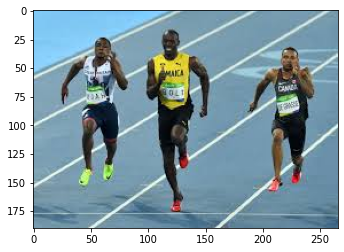

In [294]:
img = cv2.imread('bolt3.jpg')  
img = imutils.resize(img,width=min(800, img.shape[1]))
(regions, _) = hog.detectMultiScale(img, winStride=(4, 4), padding=(4, 4), scale=1.30) 
   

#for (x, y, w, h) in regions: 
   # cv2.rectangle(img,(x, y),(x + w, y + h),(0, 255, 34),2)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [295]:
print(len(regions))

3


In [296]:
croppedplayers=[]
for (x, y, w, h) in regions: 
    crimg = img[y:y+h, x:x+w]
    croppedplayers.append(crimg)

In [297]:
print(len(croppedplayers))

3


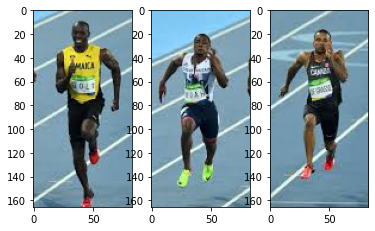

In [298]:
n: int = len(croppedplayers)
f = plt.figure()
for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(croppedplayers[i],cv2.COLOR_BGR2RGB))


In [299]:
poses=[]
for j in croppedplayers:
    op=pose_estimation(j)
    poses.append(op)


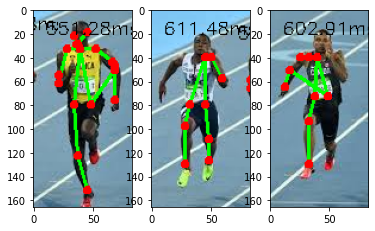

In [300]:
n: int = len(croppedplayers)
f = plt.figure()
for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(poses[i],cv2.COLOR_BGR2RGB))